In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Малая величина. Нужна для стабильности вычислений (чтобы ничего не делилось на ноль)
EPS = 1e-5

In [3]:
# обычный линейный слой, просто матричка, фактически
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0.01/np.sqrt(nin), 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db


In [4]:
# нерабочий ReLU - функция активации (передаточная функция)
class ReLU:
    def __init__(self, alpha=0.0):
        self.alpha = alpha
        
    def forward(self, x):
        y = x * (x > 0) + self.alpha*x * (x <= 0)
        self.y = y
        return y
    
    def backward(self, x):
        return 1.0 * (self.y > 0) + self.alpha * (self.y <= 0)
    
    def update(self,lr):
        pass


In [5]:
# Рабочий Tanh - функция активации (передаточная функция)
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    
    def backward(self,dy):
        return (1.0-self.y**2)*dy

In [6]:
# Рабочий Softmax -  функция активации (передаточная функция), нужный уже непосредственно для классификации
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y+EPS)
        return -log_prob.mean()
    
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / (self.p+EPS)


In [7]:
# Форма для собрки нейросетевого "бургера"
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)  
    def get_loss_acc(self, x,y,loss=CrossEntropyLoss()):
        p = self.forward(x)
        l = loss.forward(p,y)
        pred = np.argmax(p,axis=1)
        acc = (pred==y).mean()
        return l,acc

In [8]:
def train_epoch(net, train_x, train_labels, loss=CrossEntropyLoss(), batch_size=32, lr=0.001, lr_linear_down=False):
    for i in range(0,len(train_x),batch_size):
        xb = train_x[i:i+batch_size]
        yb = train_labels[i:i+batch_size]

        p = net.forward(xb)
        #print(p)
        
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)
        
    if lr_linear_down:
        # Будем линейно снижать learn rate с увеличением кол-ва эпох на 1.1
        lr = lr / 1.2

In [9]:
# Качаем обычный традиционный MNIST (цифирки)
!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 82  9.9M   82 8359k    0     0  1293k      0  0:00:07  0:00:06  0:00:01 1364k^C
gzip: mnist.pkl already exists; do you wish to overwrite (y or n)? ^C


In [9]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [10]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']
print(data.shape, labels.shape)

(42000, 784) (42000,)


### Разобьем датасет на две части: train (80%) и test (20%)

In [11]:
size = data.shape[0]
div = int(0.8*size)

train_x = 1.*data[:div]
test_x = 1.*data[div:]

train_labels = labels[:div]
test_labels = labels[div:]


Создадим несколько нейросетей, а потом сравним их качество

In [32]:
net_simple = Net()
net_simple.add(Linear(784,10))
net_simple.add(Softmax())

In [33]:
net1 = Net()
net1.add(Linear(784,100))
net1.add(Tanh())
net1.add(Linear(100,10))
net1.add(Softmax())

In [34]:
net2 = Net()
net2.add(Linear(784,200))
net2.add(Tanh())
net2.add(Linear(200,10))
net2.add(Softmax())

In [35]:
net3 = Net()
net3.add(Linear(784,100))
net3.add(Linear(100,10))
net3.add(Softmax())

In [36]:
net4 = Net()
net4.add(Linear(784,200))
net4.add(Tanh())
net4.add(Linear(200,100))
net4.add(Tanh())
net4.add(Linear(100,10))
net4.add(Softmax())

In [37]:
loss_stat0 = []
loss_stat1 = []
loss_stat2 = []
loss_stat3 = []
loss_stat4 = []

acc_stat0 = []
acc_stat1 = []
acc_stat2 = []
acc_stat3 = []
acc_stat4 = []

In [38]:
def train_epochs(net, train_x, train_y, loss_stat, acc_stat):
    loss = CrossEntropyLoss() # Будем занулять все остаточные градиенты
    EPOCHS = 10
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch}: ', end='')
        train_epoch(net,train_x,train_labels)
        loss_val, acc_val = net.get_loss_acc(train_x,train_labels)
        loss_stat += [loss_val]
        acc_stat += [acc_val]
        print(f"loss={loss_val}, accuracy={acc_val}: ")
    print()

In [39]:
train_epochs(net_simple, train_x, train_labels, loss_stat0, acc_stat0)
train_epochs(net1, train_x, train_labels, loss_stat1, acc_stat1)
train_epochs(net2, train_x, train_labels, loss_stat2, acc_stat2)
train_epochs(net3, train_x, train_labels, loss_stat3, acc_stat3)
train_epochs(net4, train_x, train_labels, loss_stat4, acc_stat4)

Epoch 0: loss=5.983813151588697, accuracy=0.4764285714285714: 
Epoch 1: loss=5.315759487218252, accuracy=0.5360714285714285: 
Epoch 2: loss=5.25371143876029, accuracy=0.5417559523809524: 
Epoch 3: loss=5.2331595686265375, accuracy=0.54375: 
Epoch 4: loss=5.0978182646623615, accuracy=0.5561904761904762: 
Epoch 5: loss=5.03851646833294, accuracy=0.5613690476190476: 
Epoch 6: loss=5.037419084522864, accuracy=0.5616369047619048: 
Epoch 7: loss=5.005108425690624, accuracy=0.5642857142857143: 
Epoch 8: loss=5.0247977882048716, accuracy=0.5623511904761904: 
Epoch 9: loss=4.997520818515187, accuracy=0.5650892857142857: 

Epoch 0: loss=0.7160676483904158, accuracy=0.8130357142857143: 
Epoch 1: loss=0.5270301778762991, accuracy=0.8625595238095238: 
Epoch 2: loss=0.450422889971405, accuracy=0.8766071428571428: 
Epoch 3: loss=0.4052190388577434, accuracy=0.8904464285714285: 
Epoch 4: loss=0.37767040595458257, accuracy=0.8958035714285715: 
Epoch 5: loss=0.35659121785552467, accuracy=0.8999702380952

In [43]:
loss_stat0 = np.array(loss_stat0)
loss_stat1 = np.array(loss_stat1)
loss_stat2 = np.array(loss_stat2)
loss_stat3 = np.array(loss_stat3)
loss_stat4 = np.array(loss_stat4)

acc_stat0 = np.array(acc_stat0)
acc_stat1 = np.array(acc_stat1)
acc_stat2 = np.array(acc_stat2)
acc_stat3 = np.array(acc_stat3)
acc_stat4 = np.array(acc_stat4)

total_loss = np.array((loss_stat0, loss_stat1, loss_stat2, loss_stat3, loss_stat4))
total_acc = np.array((acc_stat0, acc_stat1, acc_stat2, acc_stat3, acc_stat4))

### Графики Loss и Acc

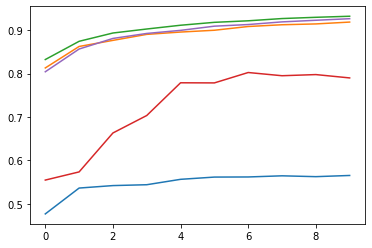

In [50]:
plt.plot(total_acc.transpose((1,0)))

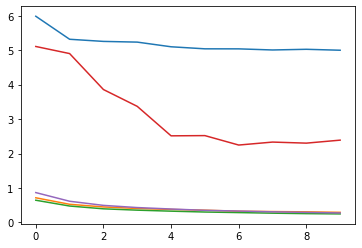

In [51]:
plt.plot(total_loss.transpose((1,0)))

In [75]:
import sklearn.metrics


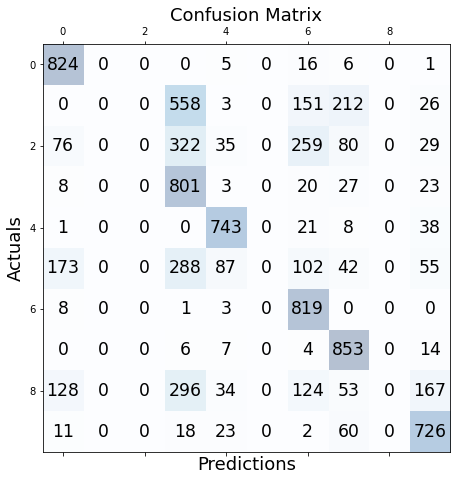

In [76]:
y_pred = np.argmax(net_simple.forward(test_x), axis=1)
conf_matrix = sklearn.metrics.confusion_matrix(y_true=test_labels, y_pred=y_pred)


fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Модель net_simple, пример распознавания и confusion_matrix

In the picture is 0


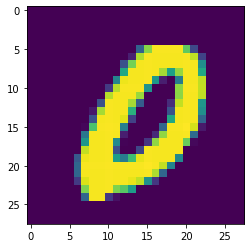

In [54]:
plt.imshow(test_x[11].reshape(28,28))
print('In the picture is', np.argmax(net_simple.forward(test_x[11])))

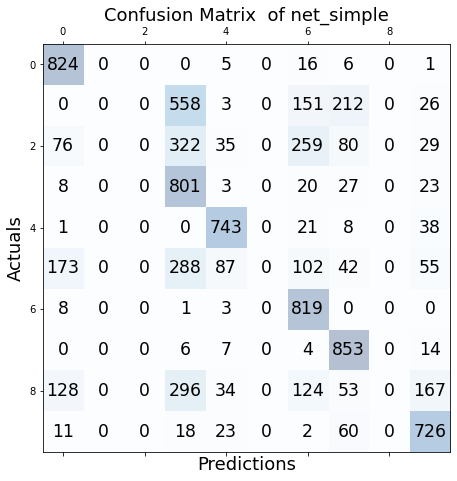

In [79]:
y_pred = np.argmax(net_simple.forward(test_x), axis=1)
conf_matrix = sklearn.metrics.confusion_matrix(y_true=test_labels, y_pred=y_pred)


fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of net_simple', fontsize=18)
plt.show()

## Модель net4, пример распознавания

In the picture is 9


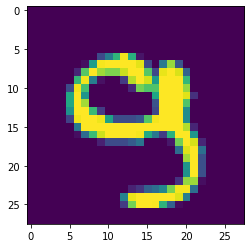

In [64]:
plt.imshow(test_x[15].reshape(28,-1))
print('In the picture is', np.argmax(net4.forward(test_x[15])))

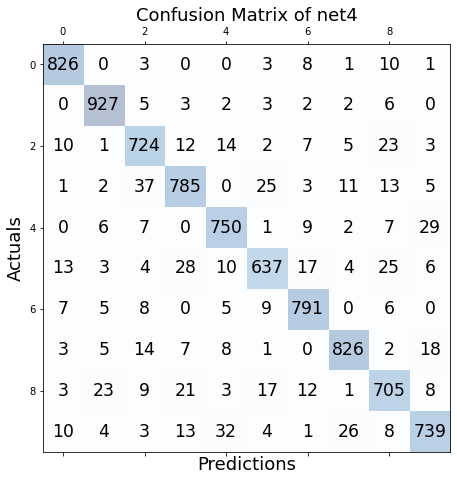

In [80]:
y_pred = np.argmax(net4.forward(test_x), axis=1)
conf_matrix = sklearn.metrics.confusion_matrix(y_true=test_labels, y_pred=y_pred)


fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of net4', fontsize=18)
plt.show()

## Выводы
Я научился самостоятельно с нуля писать нейросести, разработав свой фреймворк на чистом numpy. Также было замечено, что если внести нелинейность в модель, то модель начинает давать сильно лучше результат. Была добавлена фича по уменьшению learning rate с течением эпох (так реализовано в настоящий нейросетевых фреймворках).
Я построил графики loss с accuracy для 5-ти моделей. Разница между моделями с функцией Tanh минимальны.
Также я увидел результат нейросети на изображении с помощью matplotlib.pyplot

Работы с FachionMNIST не было